In [4]:
from Uncertainty import *
from uncertaintyMetric import *
from utils import *

K.clear_session()
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.6.2
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import matplotlib as mpl

perm: (51, 51) | logpermx: (51, 51)


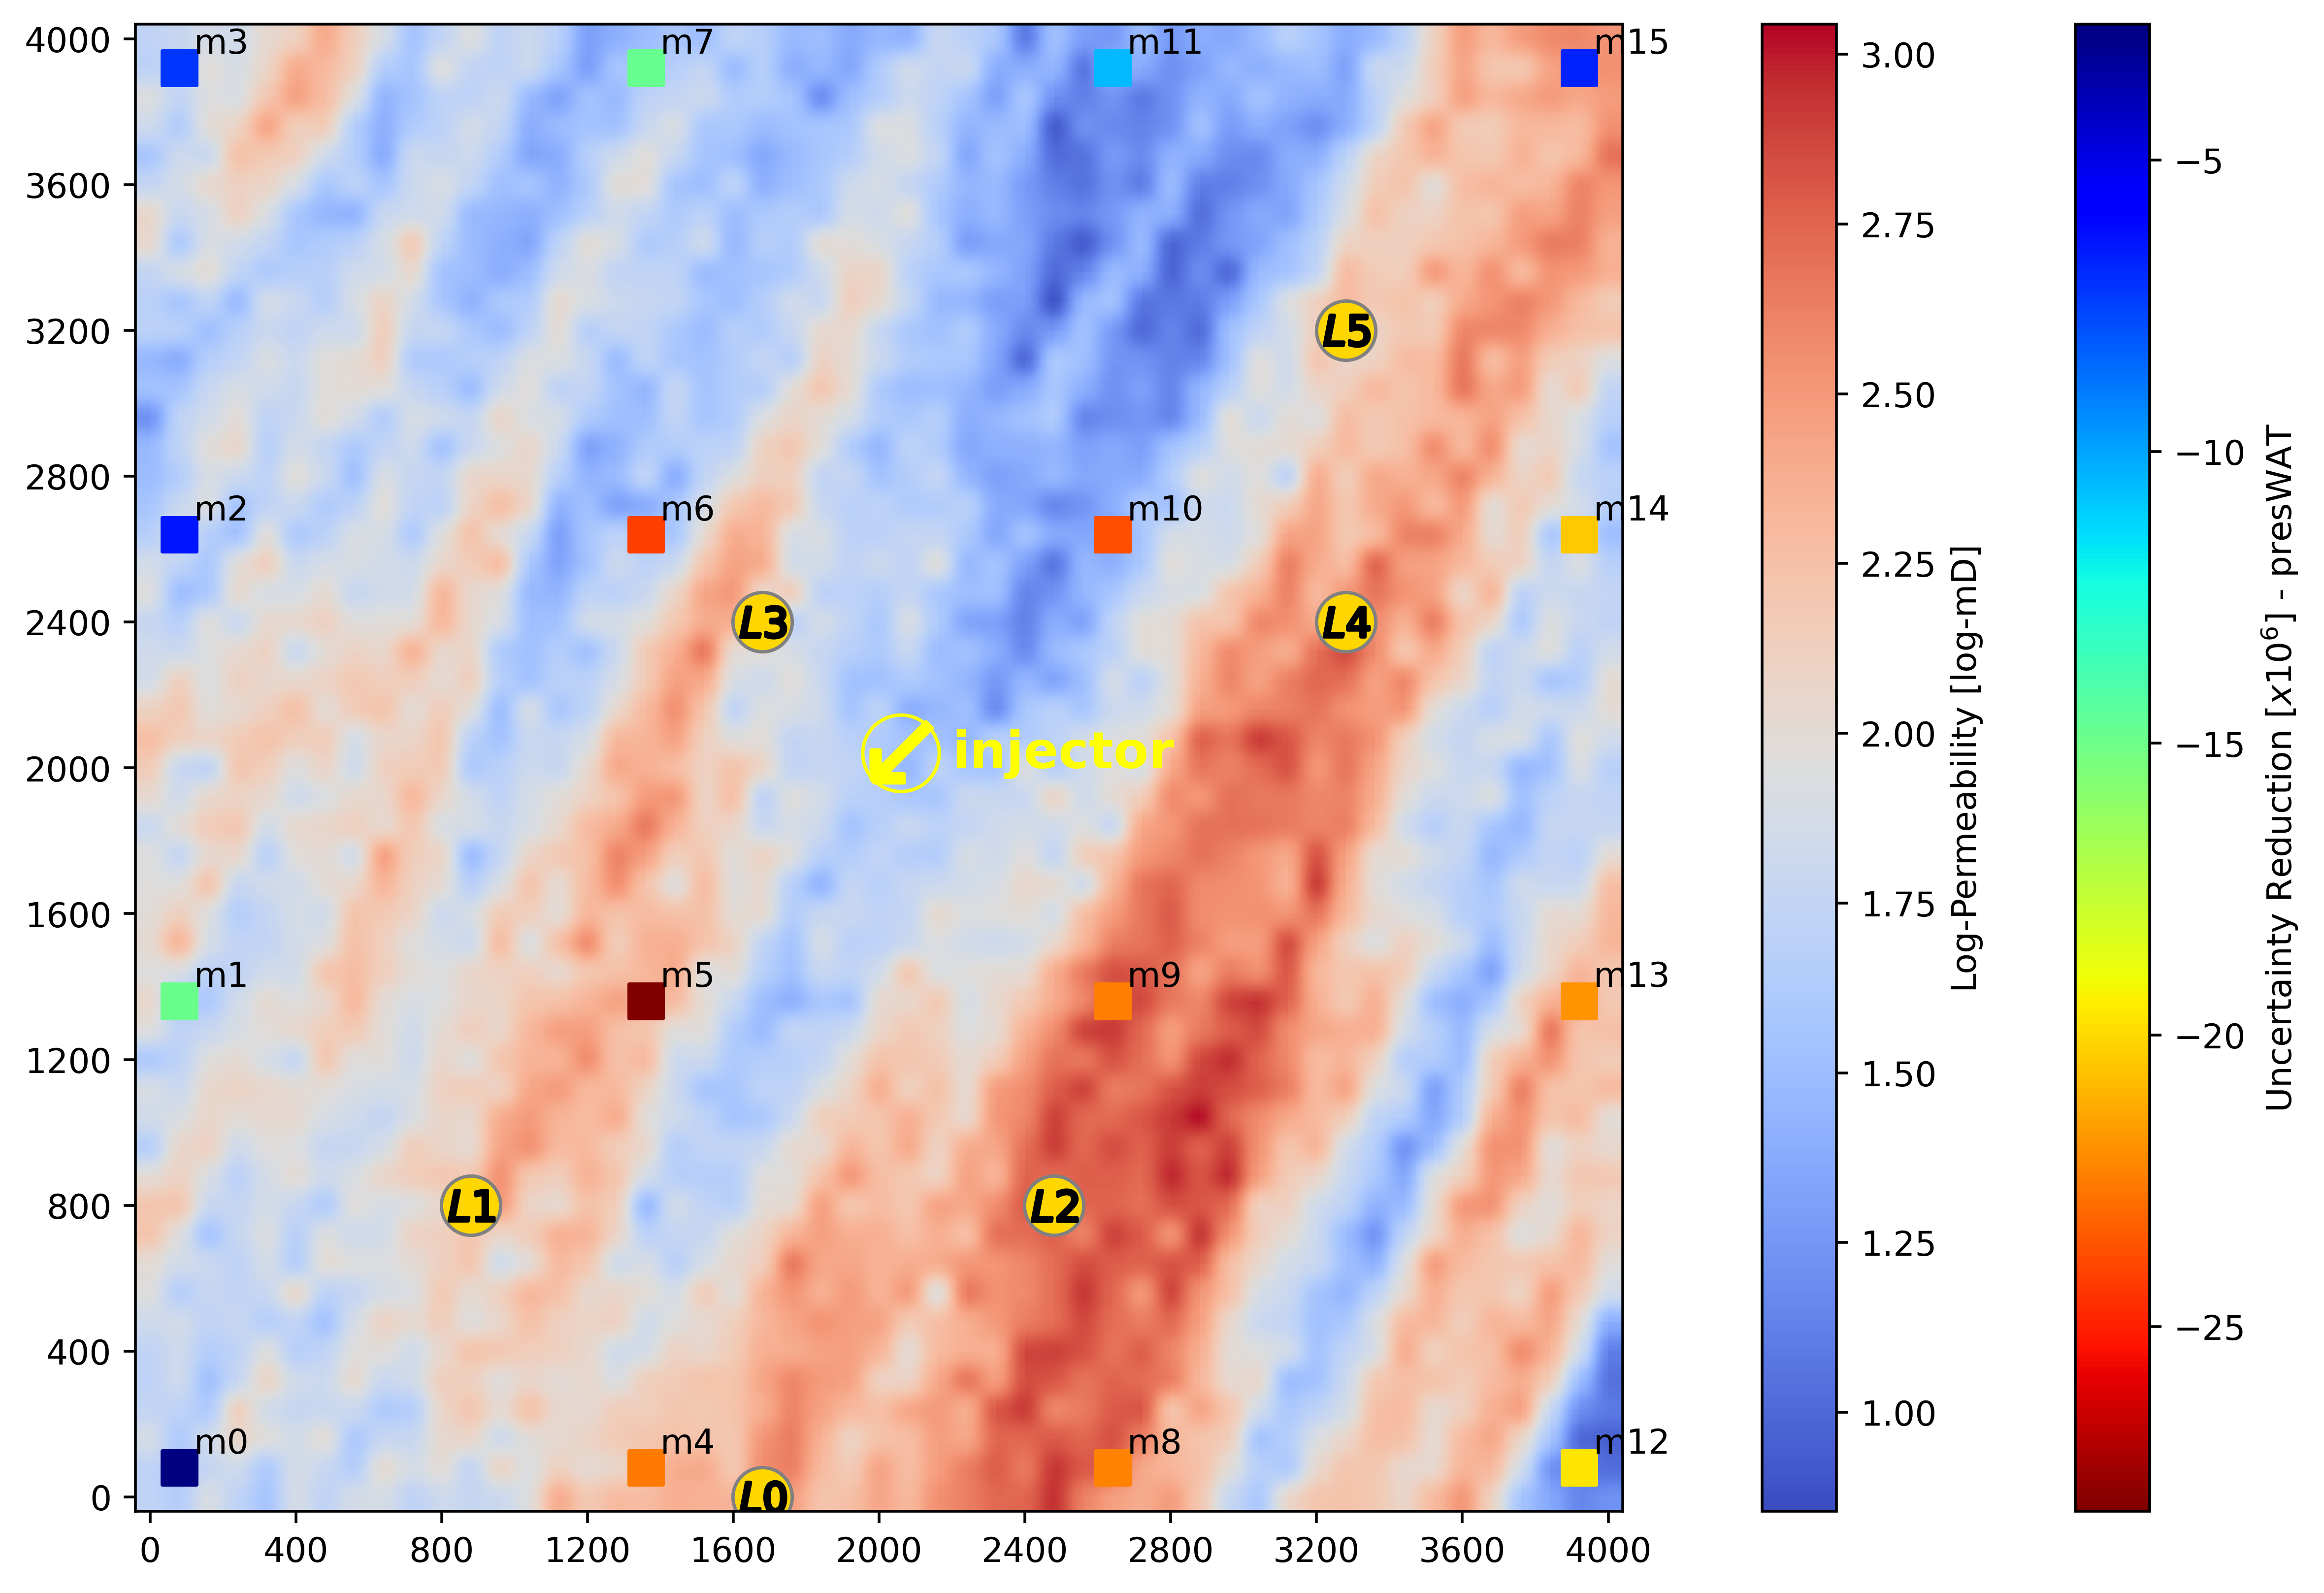

In [8]:
# permeability map
perm = np.moveaxis(np.loadtxt('perm_base.txt').reshape(10,51,51,3)[...,0], 0, -1)[...,0]
logpermx = np.log10(perm * 1.01325e15)
print('perm: {} | logpermx: {}'.format(perm.shape, logpermx.shape))

# monitoring locations
x = np.arange(1,51,step=16)
locs = np.array(list(np.array(np.meshgrid(x,x)).T)).reshape(16,2)

# leaky locations
temp = np.zeros((31,51,51)).flatten()
temp[[26531, 26551, 27561, 27581, 28091, 26031]] = 1E10
temp2 = np.flip(np.rot90(temp.reshape(31,51,51).T,3),1)
ws = np.rot90(np.array(np.where(temp2[...,10]>100)),3)

# uncertainty reduction results
ur = pd.read_csv('_misael_results/optimization_by_column.csv')
choose = 'presWAT'

### FIGURE
plt.figure(figsize=(20,8))

# permeability map
im = plt.imshow(logpermx, cmap='coolwarm', interpolation='hamming')

# injection well
plt.scatter(25.5, 25.5, c='yellow', s=500, marker='$\swarrow$')
plt.scatter(25.75, 25.5, s=500, marker='o', edgecolors='yellow', facecolors='none')
plt.text(27.5, 25, 'injector', c='yellow', size=15, weight='bold')

# leaky wells
for i in range(ws.shape[0]):
    plt.scatter(ws[i,0], ws[i,1], c='gold', s=300, edgecolors='gray')
    plt.scatter(ws[i,0], ws[i,1], c='k', marker='$L{}$'.format(i), s=180)
    
# monitoring wells
u = plt.scatter(locs[:,0], locs[:,1], c=ur[choose], marker='s', s=100, cmap='jet_r')
plt.colorbar(u, label='Uncertainty Reduction [$x10^6$] - {}'.format(choose), fraction=0.046, pad=0.04)
for i in range(locs.shape[0]):
    plt.text(locs[i,0]+0.5, locs[i,1]+0.5, 'm{}'.format(i), color='k', size=10)

# plot attributes
plt.colorbar(im, label='Log-Permeability [log-mD]', fraction=0.046, pad=0.04)
plt.xticks(np.linspace(0,50,11,dtype='int'), labels=np.linspace(0,4000,11,dtype='int'))
plt.yticks(np.linspace(0,50,11,dtype='int'), labels=np.linspace(0,4000,11,dtype='int'))
plt.gca().invert_yaxis()
mpl.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
result = pd.read_csv('_misael_results/optimization_by_column.csv')
print(result.shape)

plt.figure(figsize=(15,15))
im=plt.imshow(result.T, cmap='jet')
plt.colorbar(im, label='Uncertainty Reduction [$x10^6$]', fraction=0.009, pad=0.03)
plt.xticks(range(16), labels=np.arange(1,17)); plt.xlabel('Well Locations')
plt.yticks(range(3), labels=['presWAT','co2sl','temp']); plt.ylabel('Measure Type')
plt.title('Uncertainty Reduction by Well Location for each Measure Type')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(result, '.-')
plt.xticks(range(16), labels=np.arange(1,17)); plt.xlabel('Well Locations')
plt.ylabel('Uncertainty Reduction [$x10^6$]'); plt.grid('on')
plt.title('Uncertainty Reduction by Well Location for each Measure Type')
plt.legend(['presWAT','co2sl','temp'])
plt.show()

In [ ]:
# select       = 7
# plot_bounds  = [-3, 3]

# local_method = 'trust-krylov'
# x0           = [1.5, 1.5]
# glob_bounds  = [-2, 2]

# opt = FullOpt(select)
# local_res,  local_res_df  = opt.local_opt(x0=x0, method=local_method)
# global_res, global_res_df = opt.global_opt(varbounds=glob_bounds)
# opt.make_plot(global_res_df, local_res_df, mbounds=plot_bounds, 
#               showcontours=True, showtrajectory=True, angle=[45,225])

Brute Force

In [ ]:
view_results('LR', suptitle='Linear Regression ROM', folder='_misael_results')
view_results('MARS', suptitle='MARS ROM', folder='_misael_results')

***

In [ ]:
# General settings
Main_Directory   = os.getcwd()
Data_Directory   = os.path.join(Main_Directory, 'data')
titles           = ['.', 'Pressure', 'CO2 Saturation (l)', 'Temperature', 'Pressure + CO2 Saturation']
unc_params       = ['perm4', 'perm5', 'perm6', 'kmult']

MeasureType      = 1                           # Measurement type: 1 for pressure; 2 for CO2 saturation; 3 for tempeture, 4 for pressure+CO2 saturation                     
Total_time       = 1800                        # Total injection and post-injection time (days)
nTimeSeries      = 60                          # The number of measurement time series
nInterval        = 1                           # Measurement interval, default value = 1/Month

nTrain           = 500                         # The number of training simulations
Obj_filename     = 'run_co2mt.his'             # Objective file name
nColumn_obj      = 50                          # The column(s) in which the object of interest is located
nColumn_data     = [7]    #[7]                 # The column in which the data measurement is located 

x_max            = [1e-14, 1e-14, 1e-14, 2.0]  # Upper bounds for all the uncertain parameters
x_min            = [1e-19, 1e-19, 1e-19, 0.5]  # Lower bounds for all the uncertain parameters
ROMs_validation  = 0                           # ROMs cross-validation flag
nMCSamples       = 10000  #100000              # Number of monte carlo samples
nParam           = 4                           # Number of uncertain parameters
nDataRealization = 100    #200                 # Number of data realizations
err_option       = 3                           # Type of err option (2=MeanAE, 3=MaxAE)
time_sensitivity = 1                           # Whether consider time sensitivity for UR flag
post_processing  = 1                           # Plotting flag
print('Current Working Directory: {}'.format(Main_Directory))
print('Data Directory: {}'.format(Data_Directory))

## Step 1: Perfrom training simulation
# This step is done in a seperate code.

roms = [Ridge(), Ridge()]

***
# END